In [2]:
using Plots, DelimitedFiles, CSV
gr(fmt = "png")
#pyplot()

Plots.GRBackend()

In [3]:
# Constantes

T_c = 160 # Mev
R_c = 1
g_q = 39 + 14.25 # según Knapp
g_h = 3 + 14.25  # según Knapp


σ = 50*(197^2) # MeV^3
#σ = 50 

ξ_q = 0.7/197 # Mev
#ξ_q = 0.7 

ζ_q = 0

G = (6.70*(10^-45))
#G = 3.7835*10^(-123)

#B = g_q*(π^2/90)*T_c^4 # bag constant
B = g_q*(π^2/90)*(1 - g_h/g_q)*(T_c^4);

In [4]:
# Presiones según Kapusta

Pq(T) = g_q*(π^2/90)*T^4 - B
Ph(T) = g_h*(π^2/90)*T^4

P(h, T) = h*Ph(T) + (1-h)*Pq(T)

ΔP(T) = Ph(T) - Pq(T)

# Energías según Csernai pero con coeficientes del Kapusta

ϵ_q(T) = g_q*(π^2/30)*T^4 + B
ϵ_h(T) = g_h*(π^2/30)*T^4  

ϵ(h, T) = h*ϵ_h(T) + (1-h)*ϵ_q(T)

# Entalpías

w_q(T) = g_q*(π^2/90)*T^4 +  g_q*(π^2/30)*T^4
w_h(T) = g_h*(π^2/90)*T^4 +  g_h*(π^2/30)*T^4

w(h, T) = h*w_h(T) + (1-h)*w_q(T)

Δw(T) = w_h(T) - w_q(T)

# Velocidad de las burbujas

v(T) = 3*(1-T/T_c)^(3/2)

# Las demás

η_q(T) = 14.4*T^3

r₀(T) = (2*σ)/(Ph(T) - Pq(T)) # r_{*} en los papers

ΔF₀(T) = (4/3)*π*σ*(r₀(T))^2 # ΔF_{*} en los papers

I₀(T) = ((16/3π)*(σ/(3*T))^(3/2))*((σ*η_q(T)*r₀(T))/(ξ_q^4*(Δw(T))^2))

I(T) = (4/π)*((σ/(3*T))^(3/2))*((σ*r₀(T)*(3*ζ_q + 4*η_q(T)))/(3*ξ_q^4*(Δw(T))^2))*exp(-ΔF₀(T)/T)

# Cambio de variable

dt_dR(R, h, T) = (1/R)*((3/(8*π*G*((h*ϵ_h(T))+((1-h)*ϵ_q(T)))))^(1/2));

In [5]:
function N_density(Rs, hs, Ts, Is, factor)
    
    """
    Average bubble density, ecuación 16.56 del Kapusta.
    """
    
    Ns = []
    
    n = length(Rs)
     
    dR = Rs[2]-Rs[1]
    
    integral = 0
    
    for i in 1:n
        integral = integral + factor*(dR*dt_dR(Rs[i], hs[i], Ts[i])*Is[i]*(1-hs[i]))  
        push!(Ns, integral)
    end
     
    return Ns
end

N_density (generic function with 1 method)

Las ecuaciones a resolver son 

$$ h(R) = \int_{R_{c}}^{R} ds \frac{dt(s)}{dR} \ I(T(s))(1-h(s))V(t,s) $$
$$ \dfrac{d\epsilon}{dR} = -\dfrac{3 w(R)}{R} $$

Donde 

$$\epsilon(R) = h(R)\epsilon_{h}(T(R)) + (1-h(R))\epsilon_{q}(T(R)) = h(R)\left(g_{h}\dfrac{\pi^{2}}{90}T^4(R) \right) + (1-h(R))\left( g_{q}\dfrac{\pi^{2}}{90}T^4(R) + B \right)$$

$$w(R) = h(R)w_{h}(T(R)) + (1-h(R))w_{q}(T(R)) = h(R)\left(g_{h}\dfrac{2\pi^{2}}{45}T^4(R) \right) + (1-h(R))\left( g_{q}\dfrac{2\pi^{2}}{45}T^4(R)\right)$$

$$ \dfrac{dt}{dR} = \dfrac{1}{R} \sqrt{\dfrac{3}{8\pi G \epsilon(R)}} $$

Entonces

\begin{align*} 
\dfrac{d\epsilon}{dR} &= \dfrac{dh}{dR}\left(g_{h}\dfrac{\pi^{2}}{30}T^4(R) \right) + h(R)\left(g_{h}\dfrac{4\pi^{2}}{30}T^3(R) \dfrac{dT}{dR} \right) - \dfrac{dh}{dR}\left(g_{q}\dfrac{\pi^{2}}{30}T^4(R)  + B \right) + (1-h(R))\left( g_{q}\dfrac{4\pi^{2}}{30}T^3(R)\dfrac{dT}{dR}\right)\\
&= -\dfrac{3}{R} \left( h(R)\left(g_{h}\dfrac{2\pi^{2}}{45}T^4(R) \right) + (1-h(R))\left( g_{q}\dfrac{2\pi^{2}}{45}T^4(R)\right) \right)
\end{align*}

Haciendo cuentitas nos queda finalmente que

\begin{align}
h(R) = \int_{R_{c}}^{R} ds \frac{dt(s)}{dR} \ I(T(s))(1-h(s))V(t,s)
\end{align}

\begin{align}
\dfrac{dT}{dR} &= - \dfrac{\dfrac{dh}{dR}\left( \dfrac{g_{h}\pi^2}{30}T^{4}(R) - \dfrac{g_{q}\pi^2}{30}T^{4}(R) - B \right) + \dfrac{3}{R}\left[\dfrac{2g_{h}\pi^{2}}{45}h(R)T^{4}(R)  + (1-h(R))\left( \dfrac{2g_{q}\pi^{2}}{45}T^{4}(R) \right) \right]}{\dfrac{4g_{h}\pi^{2}}{30}h(R)T^{3}(R) + (1-h(R))\dfrac{4g_{q}\pi^{2}}{30}T^{3}(R)}
\end{align}

Las integrales las podemos aproximar con una suma inferior (tomando el extremo izquierdo, el error va como $1/N$)

\begin{align}
h(R_{k}) &= \int_{R_{c}}^{R} ds \frac{dt(s)}{dR} \ I(T(s))(1-h(s))V(t,s)  \\
&\approx \sum_{i=0}^{n-1} I(T_{i})(1-h_{i})V(R_{k},R_{i})dR \quad 
\end{align}

donde $ a_{k} = a_c + k \cdot da, \ T_{i} = T(t_{i}), \ h_{i} = h(t_{i})$ y 

\begin{align}
V(t_{i},t_{k}) &= \dfrac{4\pi}{3} \left( r_{*}(T_{i}) + 3\int_{t_{i}}^{t_{k}}ds \frac{1}{s} \sqrt{\frac{3}{8\pi G \epsilon(s)}}  \ \left( 1-\dfrac{T(s)}{T_{c}} \right)^{3/2} \right)^{3} \\
&\approx \dfrac{4\pi}{3} \left( r_{*}(T_{i}) + 3\sum_{j=i}^{m-1}dR \ \frac{1}{R_{j}} \sqrt{\frac{3}{8\pi G \epsilon(T_{j})}} \left( 1-\dfrac{T_{j}}{T_{c}} \right)^{3/2} \right)^{3} \quad t_{m} = t_{k}
\end{align}

Esas partes quedan en términos de los pasos anteriores, de modo que queda sencillo. Para la parte de la derivada notemos que 

$$ \dfrac{dh(R)}{dR} = \int_{R_{c}}^{R} ds \ I(T(s))(1-h(s))\dfrac{\partial V(s,R)}{\partial R} + I(T(R))(1-h(R))V(R,R)$$

Sin embargo no nos sirve mucho pues quedará un método implícito (se puede hacer implícito pero preferiría evitarlo), hagámos la siguiente aproximación medio chafa tomando una diferencia para atrás y veámos qué sale

$$ \dfrac{dh(R)}{dR}\Bigg|_{R=R_{i}} \approx \dfrac{h(R_{i}) - h(R_{i-1})}{dR} \approx \dfrac{h(R_{i-1}) - h(R_{i-2})}{dR}$$

In [6]:
function V(i::Number, k::Number, dR::Number, Rs::Array, hs::Array, Ts::Array)  
    """
    Esta función es para calcular el volumen, ecuación 16.55 del Kapusta.
    """
    
    integral = 0
       
    for j in i:k-1
        integral = integral + 3*dR*((1-Ts[j]/T_c)^(3/2))*dt_dR(Rs[j], hs[j], Ts[j])
    end
    
    return 4/3*π*(r₀(Ts[i]) + integral)^3    
    
end

V (generic function with 1 method)

In [7]:
function riemann_h(k::Number, dR::Number, Rs::Array, hs::Array, Ts::Array)
    
    """
    Esta función es para calcular la integral 16.50 del Kapusta.
    """
    
    integral_h = 0
    integral_V = 0
    
    for i in 1:k-1
         
        # Este if hace todo el truco para bajar la complejidad
        if i == 1
            integral = 0
            
            for j in i:k-1
                integral = integral + 3*dR*((1-Ts[j]/T_c)^(3/2))*dt_dR(Rs[j], hs[j], Ts[j])
            end 
            
            V = 4/3*π*(r₀(Ts[i]) + integral)^3 
            
            integral_h = integral_h + dR*I(Ts[i])*(1-hs[i])*V*dt_dR(Rs[i], hs[i], Ts[i])
            integral_V = integral
        
        else
            
            integral_V = integral_V - dR*3*((1-Ts[i]/T_c)^(3/2))*dt_dR(Rs[i], hs[i], Ts[i])
            V = 4/3*π*(r₀(Ts[i]) + integral_V)^3 
            
            integral_h = integral_h + dR*I(Ts[i])*(1-hs[i])*V*dt_dR(Rs[i], hs[i], Ts[i])
        end
        
    end
    
    return integral_h
    
end

riemann_h (generic function with 1 method)

In [8]:
function integro_diferencial(R_f::Number, dR::Number)
    
    Rs = []
    hs = []
    Ts = []
    
    R = R_c
    h = 0.0
    T = T_c
    
    push!(Rs, R) 
    push!(hs, h)
    push!(Ts, T)   
    
    i = 2 # Primer paso
    
    t1 = time()
    
    while R <= R_f
        
        if i == 2
            dh_dR = 0
        else 
            dh_dR = (hs[i-1]-hs[i-2])/dR 
        end
        
        fT(R, h, T) = -(dh_dR*( (g_h*π^2/30)*T^4 - (g_q*π^2/30)*T^4 - B) + (3/R)*( (2*g_h*π^2/45)*h*T^4 + (1-h)*((2*g_q*π^2/45)*T^4)) )/((4*g_h*π^2/30)*h*T^3 + (1-h)*(4*g_q*π^2/30)*T^3)
                       
        T = T + dR*fT(R,h,T)
        R = R + dR
        h = riemann_h(i, dR, Rs, hs, Ts)
        
        if h > 1
           println("R_final =$(R)")
           break
        end
        
        push!(Rs, R)
        push!(hs, h)
        push!(Ts, T)
        
        i = i+1
        
        if i % 10000 == 0
            writedlm("resultados.txt", [Rs hs Ts])
        end
        
        if i % 5000 == 0
            t2 = time()
            hours = (t2-t1)/3600
            println("i=$(i), R=$(R), h=$(h)")
            println("Van $(hours) horas \n")
        end
                       
    end
        
    return Rs, hs, Ts    
    
end  

integro_diferencial (generic function with 1 method)

In [9]:
# R_f = 1.5
# dR = 0.00001*0.2

# @time results = integro_diferencial(R_f, dR)

# Rs, hs, Ts = results;

In [10]:
datos = CSV.read("resultados_nuevos_grados.csv")

,R,h,T
,Float64⍰,Float64⍰,Float64⍰
1,1.0,0.0,160.0
2,1.0,0.0,160.0
3,1.0,0.0,159.999
4,1.00001,0.0,159.999
5,1.00001,0.0,159.999
6,1.00001,0.0,159.998
7,1.00001,0.0,159.998
8,1.00001,0.0,159.998
9,1.00002,0.0,159.997


In [11]:
Rs = datos.R
hs = datos.h
Ts = datos.T;

### Aquí las gráficas de lo que está corriendo

In [ ]:
Ts′ = [T/T_c for T in Ts]

plot(Rs, Ts′, label = "", xlabel = "R", ylabel = "T/Tc", color = "orangered")  
#scatter!(Rs, Ts′, color = "orangered", label = "")

In [ ]:
plot(Rs, hs, label = "", xlabel = "R", ylabel = "h (Hadron fraction)", color = "orangered") # Con Euler 
#scatter!(Rs, hs, color = "orangered", label = "")

In [ ]:
factor = (1.96*10.0^32)

Is = [factor*I(Ts[i]) for i = 1:length(Rs)] # ¿unidades?

println(maximum(Is))

plot(Rs, Is, label = "", xlabel = "R", ylabel = "Nucleation rate *10^44 Mev*", 
     xlims = (1.0067,1.008), color = "orangered")
scatter!(Rs, Is, color = "orangered", label = "", markersize=2)

In [ ]:
factor = (1.31*10.0^29)

Is′ = [I(Ts[i]) for i = 1:length(Rs)]

Ns = N_density(Rs, hs, Ts, Is′, factor)

println(maximum(Ns))

plot(Rs, Ns, xlabel = "R", ylabel = "N *10^48 Mev^3", label = "", color = "orangered")
scatter!(Rs, Ns, color = "orangered", label = "", markersize=2)

In [ ]:
factor = 0.1

rs = [factor*((hs[i]/(Ns[i]))*(3/(4*π)))^(1/3) for i in 1:length(Rs)]

plot(Rs, rs, legend = false, xlabel = "R", ylabel = "r (cm)", color = "orangered")

In [ ]:
Phs = [Ph(T) for T in Ts]
plot(Rs, Phs, legend = false, xlabel = "R", ylabel = "Ph (Mev^4)", color = "orangered", xlims = (1,1.01))

In [ ]:
Pqs = [Pq(T) for T in Ts]
plot(Rs, Pqs, legend = false, xlabel = "R", ylabel = "Pq (Mev^4)", color = "orangered", xlim = (1,1.01))

In [ ]:
whs = [w_h(T) for T in Ts]
plot(Rs, whs, legend = false, xlabel = "R", ylabel = "wh (Mev^4)", color = "orangered")

In [ ]:
wqs = [w_q(T) for T in Ts]
plot(Rs, wqs, legend = false, xlabel = "R", ylabel = "wq (Mev^4)", color = "orangered")

In [ ]:
ws = [w(hs[i], Ts[i]) for i in 1:length(Ts)]
plot(Rs, ws, legend = false, xlabel = "R", ylabel = "w (Mev^4)", color = "orangered")

In [ ]:
ϵhs = [ϵ_h(T) for T in Ts]
plot(Rs, ϵhs, legend = false, xlabel = "R", ylabel = "ϵh (Mev^4)", color = "orangered")

In [ ]:
ϵqs = [ϵ_q(T) for T in Ts]
plot(Rs, ϵqs, legend = false, xlabel = "R", ylabel = "ϵq (Mev^4)", color = "orangered")

In [ ]:
ϵs = [ϵ(hs[i], Ts[i]) for i in 1:length(Ts)]
plot(Rs, ϵs, legend = false, xlabel = "R", ylabel = "ϵs (Mev^4)", color = "orangered")

In [ ]:
# Ésto es para escribir todo en un archivo para hacer las gráficas en Python para que se vean bonitas
# writedlm("resultados_nuevos_grados.csv", [Rs hs Ts Is Ns rs Phs Pqs whs wqs ws ϵhs ϵqs ϵs])

### Pruebas de convergencia

Todo parece converger, de modo que el método está bien.

In [ ]:
R_convergencia = []
h_convergencia = []
T_convergencia = []

for i in 1:15
    R_f = 1.01
    dR = 0.00001*(1/i)

    @time results = integro_diferencial(R_f, dR)

    Rs, hs, Ts = results;
    
    push!(R_convergencia, Rs)
    push!(h_convergencia, hs)
    push!(T_convergencia, Ts)
    
end

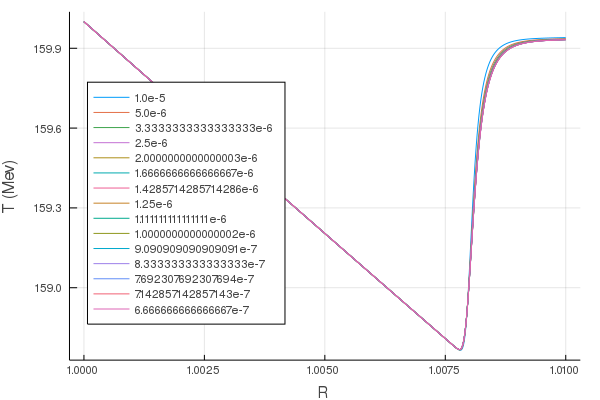

In [51]:
grafica = plot(xlabel="R", ylabel="T (Mev)")

for i in 1:15
    dR = 0.00001*(1/i)
    grafica = plot!(R_convergencia[i], T_convergencia[i], label = string(dR), legend=:bottomleft)
end

grafica

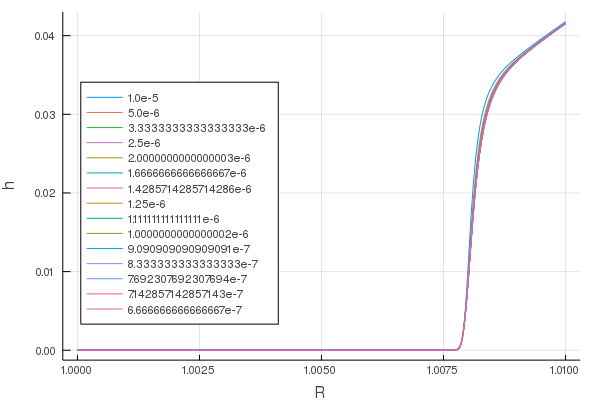

In [52]:
grafica = plot(xlabel="R", ylabel="h")

for i in 1:15
    dR = 0.00001*(1/i)
    grafica = plot!(R_convergencia[i], h_convergencia[i], label = string(dR), legend=:bottomleft)
end

grafica

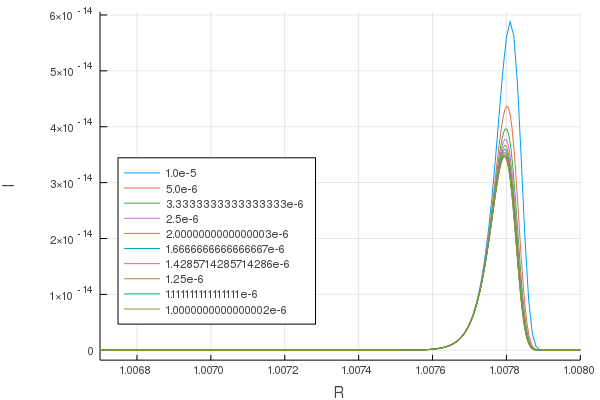

In [54]:
grafica = plot(xlabel="R", ylabel="I")

factor = (1.96*10.0^32)

for i in 1:10
    dR = 0.00001*(1/i)
    Is = [I(T)*factor for T in T_convergencia[i]] # ¿unidades?
    grafica = plot!(R_convergencia[i], Is, xlims = (1.0067,1.008), label = string(dR), legend=:bottomleft)
end

grafica

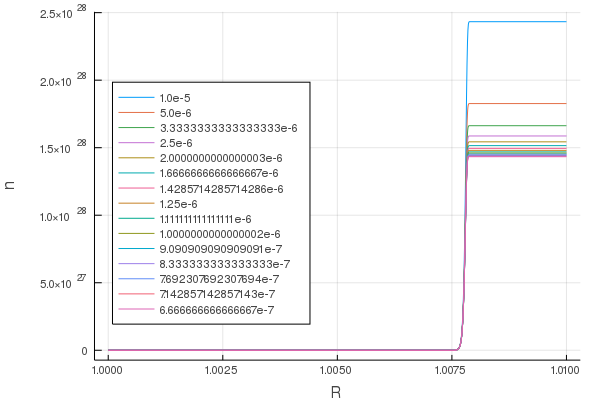

In [58]:
grafica = plot(xlabel="R", ylabel="n")

factor1 = (1.96*10.0^32)
factor2 = (1.31*10.0^29)

for i in 1:15
    dR = 0.00001*(1/i)
    
    Is = [I(T)*factor1 for T in T_convergencia[i]] # ¿unidades?
    Ns = N_density(R_convergencia[i], h_convergencia[i], T_convergencia[i], Is, factor2)
    grafica = plot!(R_convergencia[i], Ns, label = string(dR), legend=:bottomleft)
end

grafica